In [47]:
import pandas as pd
from pathlib import Path
from rdkit import Chem
from rdkit.Chem import Descriptors
import matplotlib.pyplot as plt
from typing import Tuple
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib as mpl
import numpy as np

In [48]:
mpl.rcParams["font.family"] = "Arial"

In [49]:
data_dir = Path("../datasets/raw")
consolidation_path = data_dir / "Dataset_Consolidation_canonicalized.csv"
cyanine_path = data_dir / "Dataset_Cyanine_canonicalized.csv"
xanthene_path = data_dir / "Dataset_Xanthene_canonicalized.csv"

consolidation_df = pd.read_csv(consolidation_path)
cyanine_df = pd.read_csv(cyanine_path)
xanthene_df = pd.read_csv(xanthene_path)

In [50]:
n_absorptions = consolidation_df["absorption"].notna().sum()
n_emissions = consolidation_df["emission"].notna().sum()
n_quantum_yields = consolidation_df["quantum_yield"].notna().sum()
n_log_molar_absorptivities = consolidation_df["log_molar_absorptivity"].notna().sum()

print(f"Number of absorptions: {n_absorptions}")
print(f"Number of emissions: {n_emissions}")
print(f"Number of quantum yields: {n_quantum_yields}")
print(f"Number of log_molar_absorptivities: {n_log_molar_absorptivities}")

Number of absorptions: 21707
Number of emissions: 16190
Number of quantum yields: 12481
Number of log_molar_absorptivities: 23116


In [51]:
n_absorptions = cyanine_df["absorption"].notna().sum()
n_emissions = cyanine_df["emission"].notna().sum()
n_quantum_yields = cyanine_df["quantum_yield"].notna().sum()
n_log_molar_absorptivities = cyanine_df["log_molar_absorptivity"].notna().sum()

print(f"Number of absorptions: {n_absorptions}")
print(f"Number of emissions: {n_emissions}")
print(f"Number of quantum yields: {n_quantum_yields}")
print(f"Number of log_molar_absorptivities: {n_log_molar_absorptivities}")

Number of absorptions: 1483
Number of emissions: 1096
Number of quantum yields: 715
Number of log_molar_absorptivities: 991


In [52]:
n_absorptions = xanthene_df["absorption"].notna().sum()
n_emissions = xanthene_df["emission"].notna().sum()
n_quantum_yields = xanthene_df["quantum_yield"].notna().sum()
n_log_molar_absorptivities = xanthene_df["log_molar_absorptivity"].notna().sum()

print(f"Number of absorptions: {n_absorptions}")
print(f"Number of emissions: {n_emissions}")
print(f"Number of quantum yields: {n_quantum_yields}")
print(f"Number of log_molar_absorptivities: {n_log_molar_absorptivities}")

Number of absorptions: 1147
Number of emissions: 1090
Number of quantum yields: 868
Number of log_molar_absorptivities: 617


In [41]:
def calculate_molecular_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        return Descriptors.MolWt(mol)
    else:
        return None

consolidation_df["molecular_weight"] = consolidation_df["smiles"].apply(calculate_molecular_weight)
cyanine_df["molecular_weight"] = cyanine_df["smiles"].apply(calculate_molecular_weight)
xanthene_df["molecular_weight"] = xanthene_df["smiles"].apply(calculate_molecular_weight)

In [42]:
set_colors = sns.color_palette("Set2", 3)

In [43]:
def plot_mw_distribution(df1, df2, df3, label1="Dataset 1", label2="Dataset 2", label3="Dataset 3"):
    # 只保留合法的分子质量并限制范围
    df1_filtered = df1[(df1["molecular_weight"].notna()) & (df1["molecular_weight"] <= 1500)]
    df2_filtered = df2[(df2["molecular_weight"].notna()) & (df2["molecular_weight"] <= 1500)]
    df3_filtered = df3[(df3["molecular_weight"].notna()) & (df3["molecular_weight"] <= 1500)]

    # 计算公共 bins 范围
    min_value = min(df1_filtered["molecular_weight"].min(),
                    df2_filtered["molecular_weight"].min(),
                    df3_filtered["molecular_weight"].min())
    max_value = max(df1_filtered["molecular_weight"].max(),
                    df2_filtered["molecular_weight"].max(),
                    df3_filtered["molecular_weight"].max())
    bins = np.linspace(min_value, max_value, 30)

    # 使用 Set2 色系
    palette = sns.color_palette("Set2", 3)
    color1, color2, color3 = palette[0], palette[1], palette[2]

    fig, ax = plt.subplots(dpi=600)

    # 分子质量柱状图（百分比）
    sns.histplot(
        data=df1_filtered,
        x="molecular_weight",
        bins=bins,
        stat="probability",
        kde=False,
        color=color1,
        label=label1,
        alpha=0.7,
        ax=ax
    )

    sns.histplot(
        data=df2_filtered,
        x="molecular_weight",
        bins=bins,
        stat="probability",
        kde=False,
        color=color2,
        label=label2,
        alpha=0.7,
        ax=ax
    )

    sns.histplot(
        data=df3_filtered,
        x="molecular_weight",
        bins=bins,
        stat="probability",
        kde=False,
        color=color3,
        label=label3,
        alpha=0.7,
        ax=ax
    )

    # 创建第二 y 轴用于 KDE
    ax2 = ax.twinx()

    # 计算 KDE 曲线
    x_range = np.linspace(min_value, max_value, 1000)
    kde1 = gaussian_kde(df1_filtered["molecular_weight"])
    kde2 = gaussian_kde(df2_filtered["molecular_weight"])
    kde3 = gaussian_kde(df3_filtered["molecular_weight"])

    # 缩放 KDE 曲线（匹配百分比形式）
    kde1_scaled = kde1(x_range) * (x_range[1] - x_range[0])
    kde2_scaled = kde2(x_range) * (x_range[1] - x_range[0])
    kde3_scaled = kde3(x_range) * (x_range[1] - x_range[0])

    # 绘制 KDE 曲线
    ax2.plot(x_range, kde1_scaled, color=color1, lw=1.5, label=f"{label1} KDE")
    ax2.plot(x_range, kde2_scaled, color=color2, lw=1.5, label=f"{label2} KDE")
    ax2.plot(x_range, kde3_scaled, color=color3, lw=1.5, label=f"{label3} KDE")

    # 设置坐标轴和图例
    ax.set_xlim(0, 1500)
    ax.set_xlabel("Molecular Weight", fontsize=12)
    ax.set_ylabel("Percentage", fontsize=12)
    ax.legend(loc="upper right")
    ax2.set_yticks([])



    plt.tight_layout()
    plt.show()

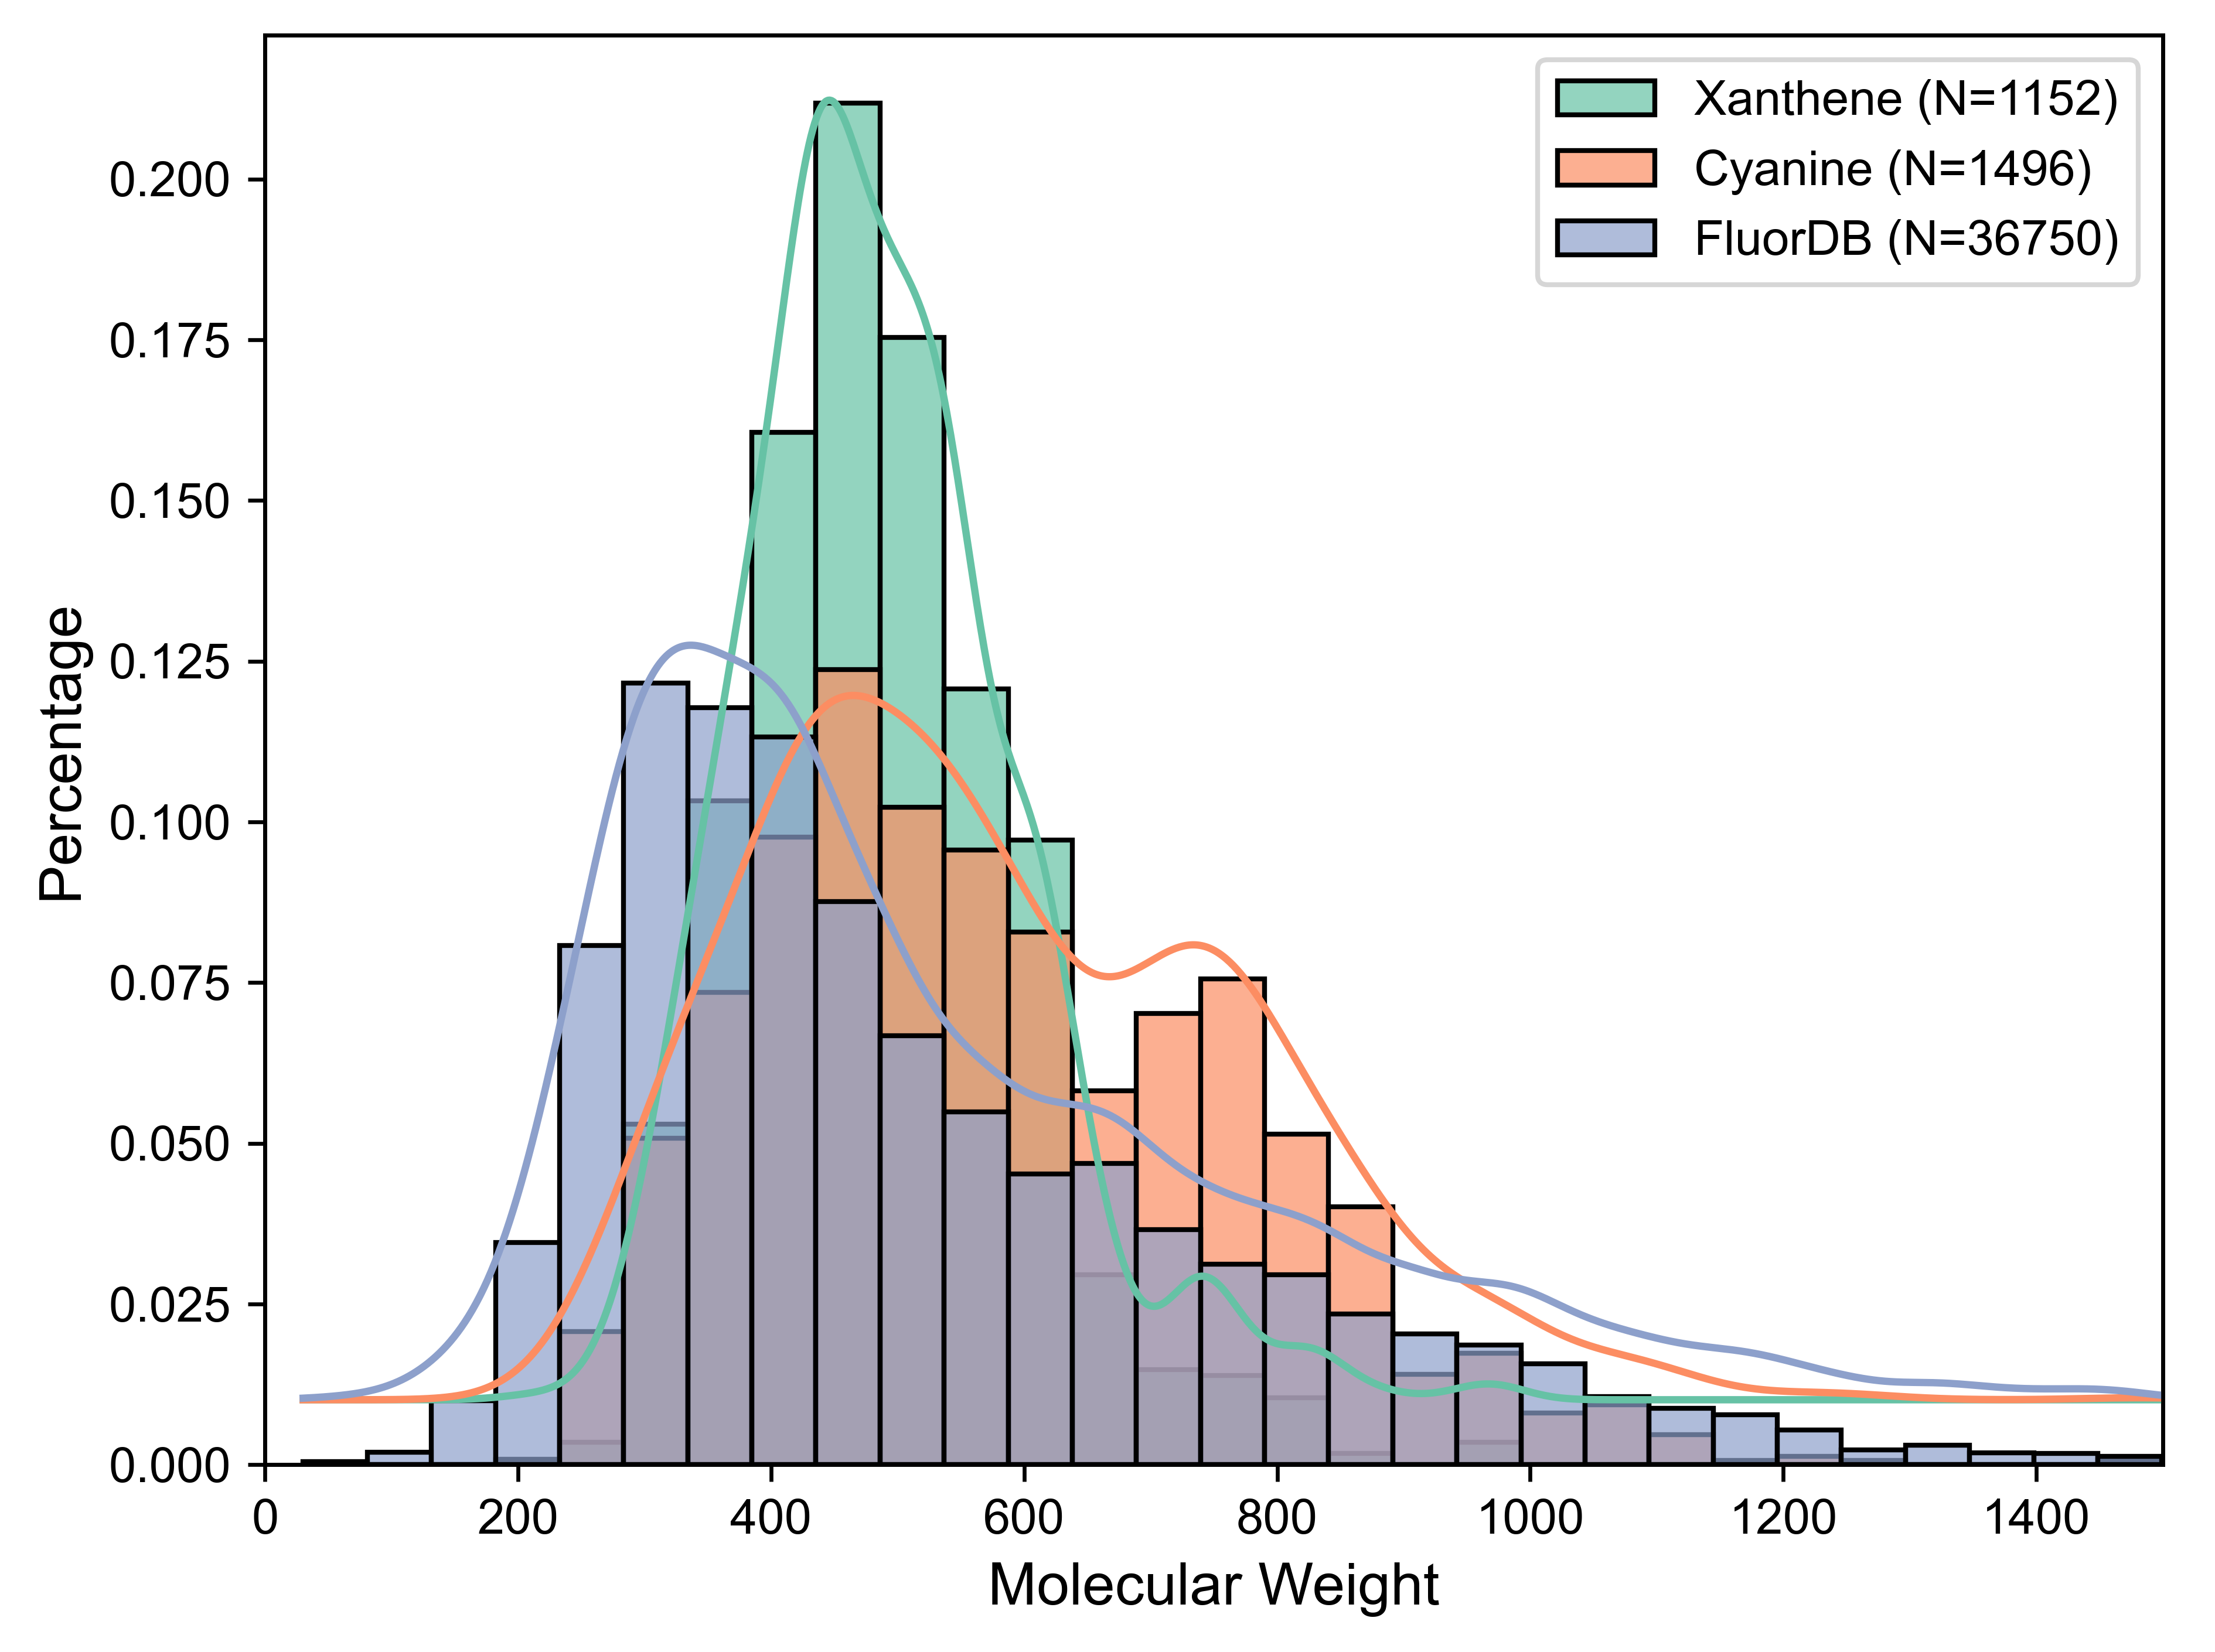

In [44]:
plot_mw_distribution(xanthene_df, cyanine_df, consolidation_df, f"Xanthene (N={len(xanthene_df)})", f"Cyanine (N={len(cyanine_df)})", f"FluorDB (N={len(consolidation_df)})")

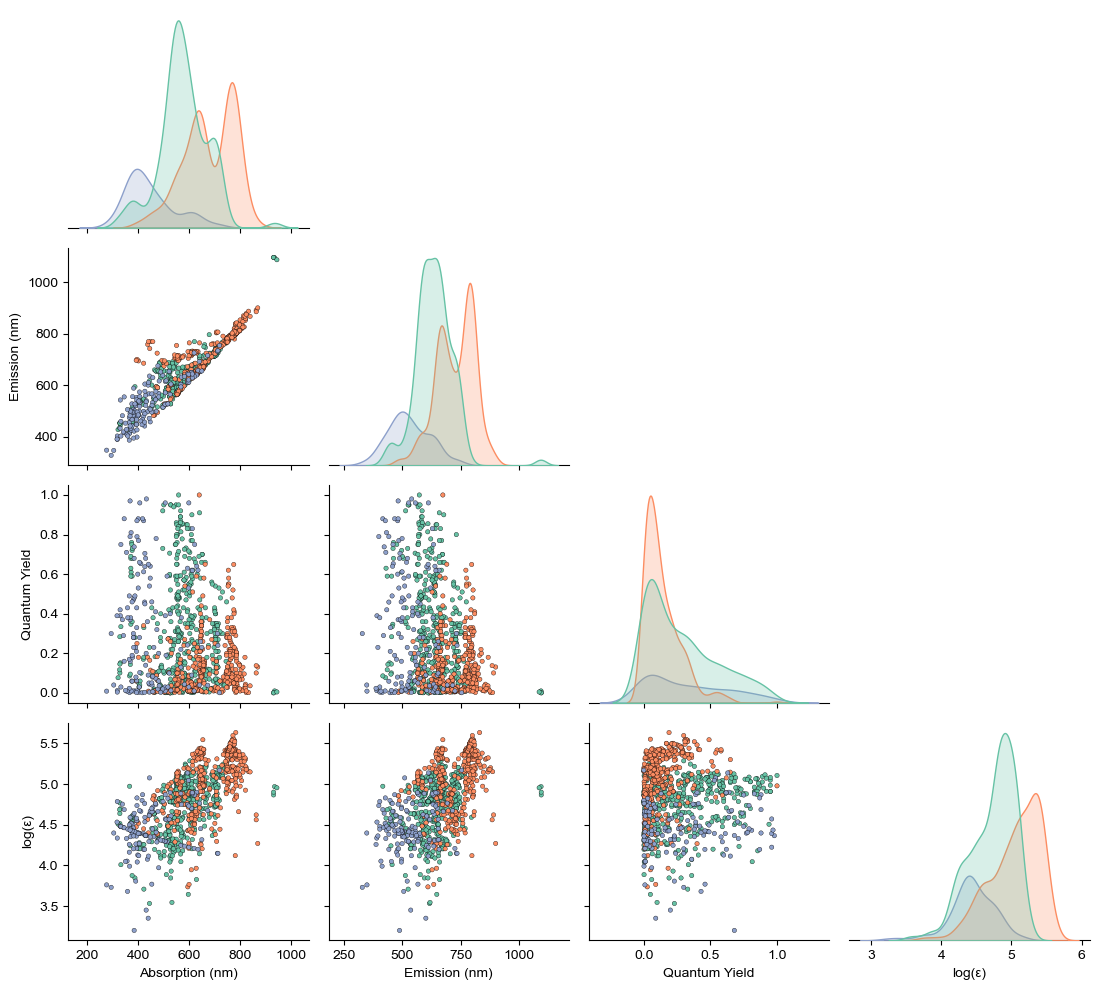

In [45]:
# 添加中文或更友好的标签
label_map = {
    "consolidation": "FluorDB",
    "cyanine": "Cyanine",
    "xanthene": "Xanthene"
}

# 添加标识列
consolidation_df["dataset"] = "consolidation"
cyanine_df["dataset"] = "cyanine"
xanthene_df["dataset"] = "xanthene"

# 每个数据集采样最多 1000 条
consolidation_sample = consolidation_df.sample(n=1000, random_state=42) if len(consolidation_df) >= 1000 else consolidation_df
cyanine_sample = cyanine_df.sample(n=1000, random_state=42) if len(cyanine_df) >= 1000 else cyanine_df
xanthene_sample = xanthene_df.sample(n=1000, random_state=42) if len(xanthene_df) >= 1000 else xanthene_df

# 合并，顺序可自定义
df_all = pd.concat([xanthene_sample, cyanine_sample, consolidation_sample])

# 替换 label
df_all["dataset"] = df_all["dataset"].map(label_map)

# 保留绘图所需列，确保数值类型
cols = ["absorption", "emission", "quantum_yield", "log_molar_absorptivity", "dataset"]
df_plot = df_all[cols].copy()


for col in cols[:-1]:
    df_plot[col] = pd.to_numeric(df_plot[col], errors='coerce')

df_plot = df_plot.dropna()
# 替换属性标签（你可以改成中文或更易懂的形式）
axis_label_map = {
    "absorption": "Absorption (nm)",
    "emission": "Emission (nm)",
    "quantum_yield": "Quantum Yield",
    "log_molar_absorptivity": "log(ε)"
}

df_plot = df_plot.rename(columns=axis_label_map)

# 配色
palette = "Set2"

# Pairplot 绘图
g = sns.pairplot(
    df_plot,
    hue="dataset",
    corner=True,
    palette=palette,
    diag_kind="kde",
    plot_kws={"alpha": 1, "edgecolor": "k", "s": 10},
    diag_kws={"fill": True}  # 关键设置 kde 曲线 alpha
)
g._legend.remove()
plt.tight_layout()
plt.show()

In [46]:
g.savefig("pairplot.png", dpi=600, bbox_inches="tight")